# Librerías

In [28]:
#Tratamiento de datos
import numpy as np
import pandas as pd

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sb

#Modelamiento
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
import multiprocessing

#Configuración de advertencias
import warnings
warnings.filterwarnings("ignore")

# **Datos**
Se simulan observaciones en dos dimensiones que van a pertenecer a 3 grupos:

- Dos variables de entrada (x1, x2)
- Una variable de salida con 3 clases (C1, C2, C3)

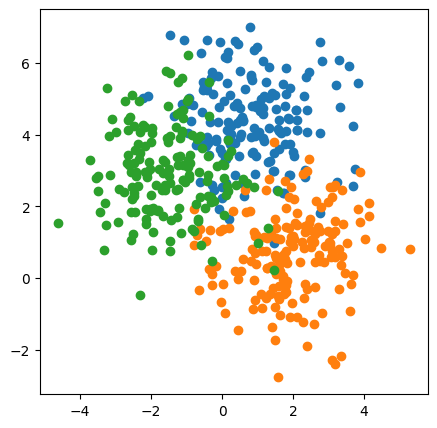

In [29]:
X, y = make_blobs(
    n_samples = 500,
    n_features = 2,
    centers = 3,
    cluster_std = 1.2,
    shuffle = True,
    random_state = 0)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))

for i in np.unique(y):
    ax.scatter(x = X[y == i, 0], y = X[y == i, 1], c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])

In [ ]:
modelo_1 = MLPClassifier(
    hidden_layer_sizes = (5),
    learning_rate_init = 0.01,
    solver = 'lbfgs',
    max_iter = 1000,
)

modelo_2 = MLPClassifier(
    hidden_layer_sizes = (10),
    learning_rate_init = 0.01,
    solver = 'lbfgs',
    max_iter = 1000,
)

modelo_3 = MLPClassifier(
    hidden_layer_sizes = (20, 20),
    learning_rate_init = 0.01,
    solver = 'lbfgs',
    max_iter = 1000,
)

modelo_4 = MLPClassifier(
    hidden_layer_sizes = (50, 50, 50),
    learning_rate_init = 0.01,
    solver = 'lbfgs',
    max_iter = 1000,
)

modelo_1.fit(X = X, y = y)
modelo_2.fit(X = X, y = y)
modelo_3.fit(X = X, y = y)
modelo_4.fit(X = X, y = y)

MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01,
              max_iter=1000, random_state=123, solver='lbfgs')

# Gráfico de Solución

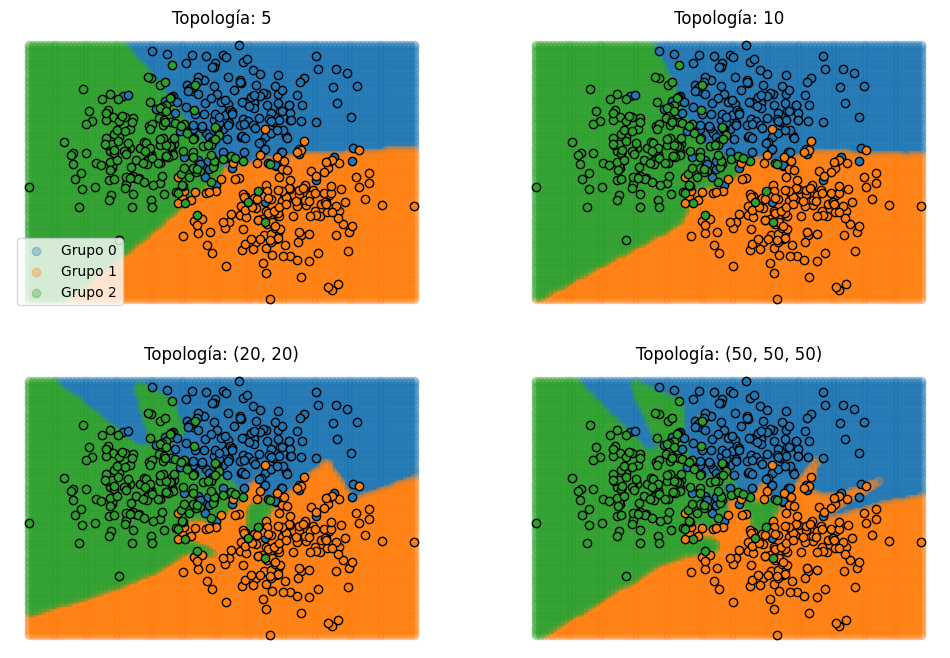

In [31]:
fig, axs = plt.subplots(2, 2, figsize = (12, 8))
axs = axs.flatten()
grid_x1 = np.linspace(start = min(X[:,0]), stop = max(X[:,0]), num = 100)
grid_x2 = np.linspace(start = min(X[:,1]), stop = max(X[:,1]), num = 100)
xx, yy = np.meshgrid(grid_x1, grid_x2)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])

for i, modelo in enumerate([modelo_1, modelo_2, modelo_3, modelo_4]):
    predicciones = modelo.predict(X_grid)
    
    for j in np.unique(predicciones):
        axs[i].scatter(x = X_grid[predicciones == j, 0],
                       y = X_grid[predicciones == j, 1],
                       c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
                       alpha = 0.3,
                       label = f'Grupo {j}')
        
    for j in np.unique(y):
        axs[i].scatter(x = X[y == j, 0],
                       y = X[y == j, 1],
                       c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
                       marker = 'o', edgecolor = 'black')
    
    axs[i].set_title(f'Topología: {modelo.hidden_layer_sizes}')
    axs[i].axis('off')
axs[0].legend()
plt.show()

## Optimización de Hiperparámetros

- Hiperparámetro: Cantidad de neuronas por capa oculta

In [32]:
param_grid = {'hidden_layer_sizes': [1, 5, 10, 25, 50] }

grid = GridSearchCV(estimator = MLPClassifier(learning_rate_init=0.01,
                                            solver='lbfgs',
                                            max_iter=5000,
                                            random_state=123),
                                            param_grid=param_grid,
                                            scoring='accuracy',
                                            cv = 5, # Folds en los que se divide el dataset. Se busca que siempre sea impar para evitar empates. No muy extensa para no perder tiempo
                                            refit=True,
                                            return_train_score=True,
                                            )
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=MLPClassifier(learning_rate_init=0.01, max_iter=5000,
                                     random_state=123, solver='lbfgs'),
             param_grid={'hidden_layer_sizes': [1, 5, 10, 25, 50]},
             return_train_score=True, scoring='accuracy')

#### **Graficar el error de la validacion cruzada**

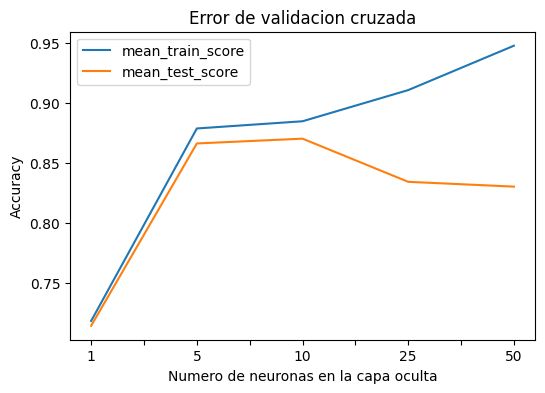

In [33]:
fig, ax = plt.subplots(figsize = (6,4))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x = 'param_hidden_layer_sizes', y = 'mean_train_score', ax = ax)
scores.plot(x = 'param_hidden_layer_sizes', y = 'mean_test_score', ax = ax)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Numero de neuronas en la capa oculta')
ax.set_title('Error de validacion cruzada')
plt.show()

- Hiperparámetro: Tasa de aprendizaje

In [34]:
param_grid = {'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] } 
grid = GridSearchCV(estimator = MLPClassifier(hidden_layer_sizes = (10),
                                            solver='lbfgs',
                                            max_iter=5000,
                                            random_state=123),
                                            param_grid=param_grid,
                                            scoring='accuracy',
                                            cv = 5, 
                                            refit=True,
                                            return_train_score=True,
                                            )


grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=MLPClassifier(hidden_layer_sizes=10, max_iter=5000,
                                     random_state=123, solver='lbfgs'),
             param_grid={'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                                100]},
             return_train_score=True, scoring='accuracy')

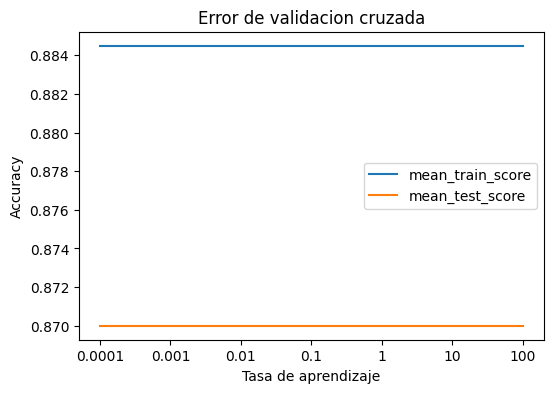

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_learning_rate_init', y='mean_train_score', ax=ax)
scores.plot(x='param_learning_rate_init', y='mean_test_score', ax=ax)
ax.set_title('Error de validacion cruzada')
ax.set_xlabel('Tasa de aprendizaje')
ax.set_ylabel('Accuracy')
plt.show()

- Hiperparámetros: Capas ocultas, neuronas de capa oculta y la tasa de aprendizaje

In [36]:
param_grid = {'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
               'hidden_layer_sizes': [(10), (10, 10), (20, 20)] } # Entre mas pequeño el learning rate, mas lento va a aprender la red neuronal. Si es muy grande, puede no converger o converger a un punto suboptimo.

grid = GridSearchCV(estimator = MLPClassifier(solver='lbfgs',
                                            max_iter=5000,
                                            random_state=123),
                                            param_grid=param_grid,
                                            scoring='accuracy',
                                            cv = 5, # Folds en los que se divide el dataset. Se busca que siempre sea impar para evitar empates. No muy extensa para no perder tiempo
                                            refit=True,
                                            return_train_score=True,
                                            )

grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=MLPClassifier(max_iter=5000, random_state=123,
                                     solver='lbfgs'),
             param_grid={'hidden_layer_sizes': [10, (10, 10), (20, 20)],
                         'learning_rate_init': [0.0001, 0.001, 0.01, 0.1]},
             return_train_score=True, scoring='accuracy')

In [37]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = 'param_*|mean_t|std_t').drop(columns='params').sort_values('mean_test_score', ascending=False)

,param_hidden_layer_sizes,param_learning_rate_init,mean_test_score,std_test_score,mean_train_score,std_train_score
0,10,0.0001,0.870,0.034059,0.8845,0.012288
1,10,0.001,0.870,0.034059,0.8845,0.012288
2,10,0.01,0.870,0.034059,0.8845,0.012288
3,10,0.1,0.870,0.034059,0.8845,0.012288
4,"(10, 10)",0.0001,0.854,0.023324,0.9045,0.008860
5,"(10, 10)",0.001,0.854,0.023324,0.9045,0.008860
6,"(10, 10)",0.01,0.854,0.023324,0.9045,0.008860
7,"(10, 10)",0.1,0.854,0.023324,0.9045,0.008860
8,"(20, 20)",0.0001,0.822,0.030594,0.9350,0.005701
9,"(20, 20)",0.001,0.822,0.030594,0.9350,0.005701


In [38]:
modelo = grid.best_estimator_
modelo

MLPClassifier(hidden_layer_sizes=10, learning_rate_init=0.0001, max_iter=5000,
              random_state=123, solver='lbfgs')

Iteración para Graficar

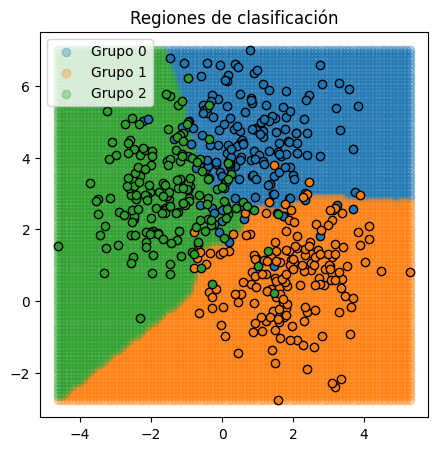

In [39]:
predicciones = modelo.predict(X_grid)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in np.unique(predicciones):
    ax.scatter( x = X_grid[predicciones == i, 0],
                y = X_grid[predicciones == i, 1],
                c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i], 
                alpha=0.3, 
                label = f'Grupo {i}')
    
for i in np.unique(y):
    ax.scatter( x = X[y == i, 0],
                y = X[y == i, 1],
                c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i], 
                marker= 'o', edgecolors= 'black',
                )
ax.set_title('Regiones de clasificación')
ax.legend()
plt.show()